In [7]:
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 17 11:13:04 2022

@author: LuTimothy
"""

import cv2
import os
import glob
import numpy as np
import torch
from sys import platform

import torch
import torchvision.transforms as T
from PIL import Image

from matplotlib import pyplot as plt

torch.set_default_tensor_type(torch.FloatTensor)


path = os.getcwd() 

if platform == 'darwin':
    slash = '/'
else: 
    slash = '\\'



In [8]:
def load(folder):
    files = glob.glob(folder)
    data =[]
    for f in files:
        image = cv2.imread(f)
        data.append(image)
    return data
    #need to change height and width to 128
    #also need to get randindexes?
    


def resize(album):
    for index, photo in enumerate(album):
        #have to get the photo from numpy array to pillow object
        transform_pil = T.ToPILImage()
        photo = transform_pil(photo)
    
        transform_size = T.Resize((128,128))
        img = transform_size(photo)
        album[index] = img
          #album[index] = image
    return album
    #album = np.stack(album,axis = 3)
    

        

def convert(album):
    #convert everything in the lists to tensors
    #then stack list of tensors
    #to get 4d tensor
     for index, img in enumerate(album):
         make_tensor = T.ToTensor()
         img = make_tensor(img)
         album[index] = img
         if(img) == None:
             print('there is none object')
    #should convert list of tensors to 4d tensor
     album = torch.stack(album)
     
     return album  
     

        
def ShuffleData(album):
    # get random permutation of indices
    indices = torch.randperm(album.shape[0])
    
    # return album in order of random permutation of indices
    return album[indices]
    

    
def AugmentData(album, xTimesSamples=10, keepOriginal=True, min_percent_crop=0.5):
    # using OpenCV
    # Flip, Random Crop, RGB Scaling
    
    # create empty tensor of 10x more samples w/ same dimensions
    album_new = torch.zeros([album.shape[0]*xTimesSamples] + [album.shape[i] for i in range(1,len(album.shape))])
    
    # if specified to keep the original data
    if keepOriginal:
        album_new[0:album.shape[0]] = album[np.random.permutation(album.shape[0])]
        count = album.shape[0]
    else:
        count = 0
        
    # until sample is filled in
    while count < album_new.shape[0]:
        
        # create random permutation of all the data indices
        indices = np.random.permutation(album.shape[0])
    
        # for each image in the above permutation
        for ind in indices:
            # get image and augment image
            image = album[ind]
            image = AugmentImage(image, min_percent_crop=min_percent_crop)
            
            # store augmented image in tensor
            album_new[count] = image

            # increase count
            count = count + 1
            
    return album_new
            
            
            
def AugmentImage(image, min_percent_crop=0.5):
    
    # convert image to numpy array
    image = image.numpy()
    
    # number of augmentation strategies
    numAugStrat = 3
    
    # get a random permutation of 0 to 2 (index for augmentation technique)
    augTechs = np.random.permutation(numAugStrat)

    # random number of augmentations to use
    numAugTechs = np.random.randint(1, numAugStrat+1)

    # for each sample, perform random augmentation techniques
    augTechs = augTechs[0:numAugTechs]
    for augNum in augTechs:
        # horizontally flip image
        if augNum == 0:
            image = cv2.flip(image, 1)

        # crop and resize image
        if augNum == 1:
            crop_dim = np.random.randint(int(min_percent_crop*image.shape[-2]), image.shape[-2])
            image = RandomCrop(image, crop_dim, crop_dim)

        # rgb scaling for image
        if augNum == 2:
            scale = np.random.uniform(low=0.6, high=1)
            image = image * scale
    
    # convert image back to tensor and return result
    image = torch.Tensor(image)
                    
    return image
                    
    
    
    
# First 7 lines from RandomCrop from: https://stackoverflow.com/questions/42263020/opencv-trying-to-get-random-portion-of-image 
def RandomCrop(image, crop_height, crop_width):
    # get size of 
    max_x = image.shape[-1] - crop_width
    max_y = image.shape[-2] - crop_height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)
    
    crop = np.zeros([image.shape[-3], crop_height, crop_width])
    cropResize = np.zeros([image.shape[-3], image.shape[-2], image.shape[-1]])
    for i in range(0, image.shape[-3]):
        crop[i] = image[i][y: y + crop_height, x: x + crop_width]
        cropResize[i] = cv2.resize(crop[i], (image.shape[-2], image.shape[-1]))

    return cropResize
        

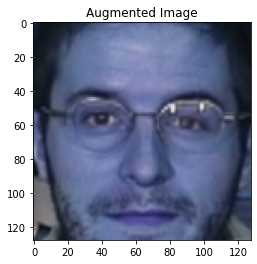

In [10]:
plt.imshow(album_faces[0].permute(-2, -1, -3));
plt.title("Original Image");

plt.imshow(AugmentImage(album_faces[0], min_percent_crop=0.75).permute(-2, -1, -3));
plt.title("Augmented Image");

album_faces_aug = ShuffleData(AugmentData(album_faces, xTimesSamples=10, keepOriginal=True, min_percent_crop=0.75))
plt.imshow(album_faces_aug[125].permute(-2, -1, -3))

In [9]:
face_path = path + slash + 'face_images'
originals_path = path + slash + 'ColorfulOriginal'
grayscale_path = path + slash + 'gray'

# for name in glob.glob(face_path + slash + '*', recursive = True):
#     print(name)    


album_faces = load(face_path + slash +'*.jpg')
# album_colors = load(originals_path + slash + '**' + slash +'*.jpg')
# album_gray = load(grayscale_path + slash + '**' + slash +'*.jpg')

#note album_faces is already size 128x128 does not need to be resized
album_faces = convert(album_faces)

# album_colors = resize(album_colors)
# album_colors = convert(album_colors)

# album_gray =resize(album_gray)
# album_gray = convert(album_gray)

In [138]:
def ImageToLAB(image):
#     new_album = torch.zeros([i for i in album.shape])
#     for i, im in enumerate(album):
#         new_album[i] = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
    new_image = cv2.cvtColor(image.permute(1, 2, 0).numpy(), cv2.COLOR_BGR2LAB)
        
    return new_image


# album_faces_aug_LAB = ImageToLAB(album_faces_aug[0])
# print(image.permute(-2, -1, -3))

imageLAB = ImageToLAB(album_faces_aug[0])
L,a,b=cv2.split(imageLAB)
cv2.imshow("LChannel", L) #album_faces[0].permute(1, 2, 0).numpy())
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imshow('aChannel', a)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imshow('bChannel', b)
cv2.waitKey(0)
cv2.destroyAllWindows()